<a href="https://colab.research.google.com/github/Navash914/APS360_ArtificialIntelligenceFundamentals/blob/master/Lab4/Lab_4_Data_Imputation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4: Data Imputation using an Autoencoder

**Deadline**: Thursday, March 5, 11:59pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Chris Lucasius

In this lab, you will build and train an autoencoder to impute (or "fill in") missing data. 

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available 
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features. 

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features 
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link:

In [0]:
import csv
import numpy as np
import random
import torch
import torch.utils.data

## Part 0

We will be using a package called `pandas` for this assignment. 

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here: 
https://pandas.pydata.org/pandas-docs/stable/install.html

In [0]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [0]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

In [54]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset. 

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`. 

Like numpy arrays and torch tensors, 
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [55]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names, 
for example `df["race"]`, `df["hr"]`, or even index multiple columns 
like below.

In [56]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [57]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1` 

would increment everyone's age by 1.

In [58]:
cols = ["age", "yredu", "capgain", "caploss", "workhr"]
vals = df[cols]

min_vals = vals.min(0)
max_vals = vals.max(0)
avg_vals = vals.sum(0)/vals.shape[0]
min_max_avg = pd.concat([min_vals, max_vals, avg_vals], axis=1)
min_max_avg = min_max_avg.rename(columns={0:"min", 1:"max", 2:"average"})
min_max_avg

,min,max,average
age,17,90,38.581647
yredu,1,16,10.080679
capgain,0,99999,1077.648844
caploss,0,4356,87.303830
workhr,1,99,40.437456


In [59]:
for col in cols:
  df[col] = (df[col] - min_vals[col]) / (max_vals[col] - min_vals[col])
df[:3]

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,0.301370,State-gov,77516,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,83311,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.00000,0.0,0.122449,United-States
2,0.287671,Private,215646,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.00000,0.0,0.397959,United-States


### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [63]:
num_male = sum(df["sex"] == " Male")
# Not doing 1-num_male because some values may be missing
num_female = sum(df["sex"] == " Female")

percent_male = 100 * num_male / df.shape[0]
percent_female = 100 * num_female / df.shape[0]

print("{0:.2f}% of people in the data set are male".format(percent_male))
print("{0:.2f}% of people in the data set are female".format(percent_female))

66.92% of people in the data set are male
33.08% of people in the data set are female


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [0]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [0]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

In [67]:
num_missing = df_with_missing.shape[0]
percent_missing = 100 * num_missing / df.shape[0]
print("{0} records contained missing features.".format(num_missing))
print("{0:.2f}% of records were removed.".format(percent_missing))

1843 records contained missing features.
5.66% of records were removed.


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [69]:
possible_work_vals = set(df_not_missing.work)
possible_work_vals

{' Federal-gov',
 ' Local-gov',
 ' Private',
 ' Self-emp-inc',
 ' Self-emp-not-inc',
 ' State-gov',
 ' Without-pay'}

We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`. 

In [0]:
data = pd.get_dummies(df_not_missing)

In [71]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,work_ State-gov,work_ Without-pay,marriage_ Divorced,marriage_ Married-AF-spouse,marriage_ Married-civ-spouse,marriage_ Married-spouse-absent,marriage_ Never-married,marriage_ Separated,marriage_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,edu_ 10th,edu_ 11th,edu_ 12th,edu_ 1st-4th,edu_ 5th-6th,edu_ 7th-8th,edu_ 9th,edu_ Assoc-acdm,edu_ Assoc-voc,edu_ Bachelors,edu_ Doctorate,edu_ HS-grad,edu_ Masters,edu_ Preschool,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,0.452055,0.800000,0.00000,0.0,0.122449,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,0.287671,0.533333,0.00000,0.0,0.397959,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [72]:
num_cols = data.shape[1]
num_cols

57

The number came from expanding all the categorical columns into one-hot encoded values.

### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not 
actually be "one-hot" -- the input may instead 
contain real-valued predictions from our neural network.

In [0]:
datanp = data.values.astype(np.float32)

In [0]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.
    
    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.
    
    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`
        
    Examples:
    
    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    # <----- TODO: WRITE YOUR CODE HERE ----->
    # You may find the variables `cat_index` and `cat_values` 
    # (created above) useful.
    return cat_values[feature][np.argmax(onehot)]

In [0]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [0]:
from torch.utils.data.sampler import SubsetRandomSampler

def get_data_loader(dataset, batch_size=256):
  np.random.seed(50)

  num_samples = dataset.shape[0]

  # Randomize indices list
  indices = list(range(num_samples))
  np.random.shuffle(indices)

  # Allocate relevant loaders
  num_train = int(num_samples * 0.7) # 70% of total
  num_val = int(num_samples * 0.15) # 15% of total
  # test is the remaining 20%

  split1, split2 = num_train, num_train + num_val
  train_indices, val_indices, test_indices = indices[:split1], indices[split1:split2], indices[split2:]

  train_sampler = SubsetRandomSampler(train_indices)
  val_sampler = SubsetRandomSampler(val_indices)
  test_sampler = SubsetRandomSampler(test_indices)

  train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                              num_workers=1, sampler=train_sampler)
  val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
  test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                              num_workers=1, sampler=test_sampler)
  return train_loader, val_loader, test_loader

In [114]:
train_loader, val_loader, test_loader = get_data_loader(datanp, batch_size=1)
print("Number of training items:", len(train_loader))
print("Number of validation items:", len(val_loader))
print("Number of test items:", len(test_loader))

Number of training items: 21502
Number of validation items: 4607
Number of test items: 4609


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information 
about ~11 features.

In [0]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.name = "ae"
        hidden1 = 46
        hidden2 = 34
        hidden3 = 22
        encodim_dim = 11
        self.encoder = nn.Sequential(
            nn.Linear(57, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, hidden3),
            nn.ReLU(),
            nn.Linear(hidden3, encodim_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encodim_dim, hidden3),
            nn.ReLU(),
            nn.Linear(hidden3, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, 57),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

## Part 3. Training [18] 

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [0]:
def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the 
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def train(model, train_loader, valid_loader, batch_size=256, learning_rate=1e-4, num_epochs=5, plot=False):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Set up some numpy arrays to store the training/test loss/accuracy
    train_acc = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    print('Started Training')

    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_val_loss = 0.0
        total_epoch = 0

        for data in train_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_train_loss += loss.item()
            total_epoch += 1
        
        train_acc[epoch] = get_accuracy(model, train_loader)
        val_acc[epoch] = get_accuracy(model, valid_loader)

        train_loss[epoch] = float(total_train_loss) / total_epoch

        total_epoch = 0
        for data in val_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, data)
            total_val_loss += loss.item()
            total_epoch += 1

        val_loss[epoch] = float(total_val_loss) / total_epoch

        print(("Epoch {}: Train acc: {}, Train loss: {} |"+
               "Validation acc: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_acc[epoch],
                   train_loss[epoch],
                   val_acc[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)
    
    print('Finished Training')
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_acc.csv".format(model_path), val_acc)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

    if plot:
      plot_training_curve(model_path)


import matplotlib.pyplot as plt
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    train_acc = np.loadtxt("{}_train_acc.csv".format(path))
    val_acc = np.loadtxt("{}_val_acc.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    params = path.split("_")
    for param in params:
      if param.startswith("bs"):
        bs = param[2:]
      if param.startswith("lr"):
        lr = param[2:]
    title = "Train vs Validation Accuracy (bs = " + bs + ", lr = " + lr + ")"
    plt.title(title)
    n = len(train_acc) # number of epochs
    plt.plot(range(1,n+1), train_acc, label="Train")
    plt.plot(range(1,n+1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    title = "Train vs Validation Loss (bs = " + bs + ", lr = " + lr + ")"
    plt.title(title)
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few 
iterations as part of your training curve.

In [0]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature, 
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the 
    record. The returned "accuracy" measure is the percentage of times 
    that our model is successful.
        
    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

Started Training
Epoch 1: Train acc: 0.4598486962453105, Train loss: 0.15189346564667566 |Validation acc: 0.45861370378409666, Validation loss: 0.07281186597214805
Epoch 2: Train acc: 0.4562056242830124, Train loss: 0.07063412355879943 |Validation acc: 0.4555748498661457, Validation loss: 0.06943741192420323
Epoch 3: Train acc: 0.48856695501193687, Train loss: 0.06747121488054593 |Validation acc: 0.4882425294841184, Validation loss: 0.0631808251556423
Epoch 4: Train acc: 0.5454376337084922, Train loss: 0.05796171746970642 |Validation acc: 0.5458360465957601, Validation loss: 0.05484589396251573
Epoch 5: Train acc: 0.5713422007255139, Train loss: 0.05399092841183856 |Validation acc: 0.5706533535923595, Validation loss: 0.0526190921664238
Epoch 6: Train acc: 0.5735978048553623, Train loss: 0.05152794434910729 |Validation acc: 0.5738007380073801, Validation loss: 0.049058327451348305
Epoch 7: Train acc: 0.5787213592534027, Train loss: 0.04787716105402935 |Validation acc: 0.579589031184429

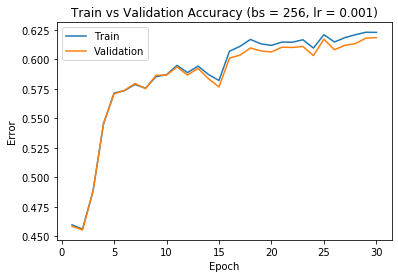

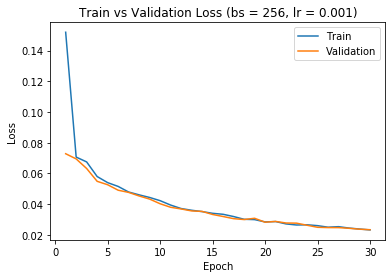

In [131]:
# Hyperparameters
bs = 256
lr = 0.001
ne = 30

# Model
model = AutoEncoder()

# Get data loaders
train_loader, val_loader, test_loader = get_data_loader(datanp, bs)

# Train and plot
train(model, train_loader, val_loader, bs, lr, ne, True)

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you 
chose the next set of hyperparameters to try.

Started Training
Epoch 1: Train acc: 0.45454686385762566, Train loss: 0.1419445870532876 |Validation acc: 0.45235511178641197, Validation loss: 0.07282143831253052
Epoch 2: Train acc: 0.4598486962453105, Train loss: 0.07111134921156224 |Validation acc: 0.45861370378409666, Validation loss: 0.0702420783539613
Epoch 3: Train acc: 0.4598486962453105, Train loss: 0.06947963019566876 |Validation acc: 0.45861370378409666, Validation loss: 0.06829063635733393
Epoch 4: Train acc: 0.5130065420270983, Train loss: 0.0658026398381307 |Validation acc: 0.5142174951161276, Validation loss: 0.06133433534867234
Epoch 5: Train acc: 0.5613508820884879, Train loss: 0.05727102793753147 |Validation acc: 0.5598364807177484, Validation loss: 0.055185358971357346
Epoch 6: Train acc: 0.5796127492016246, Train loss: 0.05403729612451224 |Validation acc: 0.5788293177049417, Validation loss: 0.053388661394516625
Epoch 7: Train acc: 0.5839456794716771, Train loss: 0.052577654077183636 |Validation acc: 0.583242891252

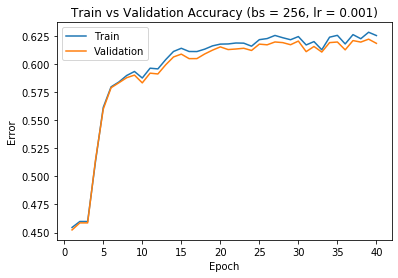

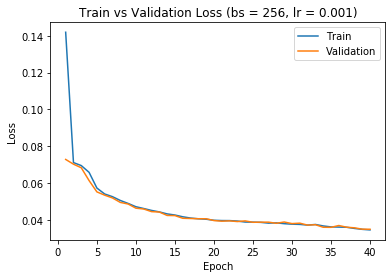

In [148]:
# Hyperparameters
bs = 256
lr = 0.001
ne = 40

# Model
model = AutoEncoder()

# Get data loaders
train_loader, val_loader, test_loader = get_data_loader(datanp, bs)

# Train and plot
train(model, train_loader, val_loader, bs, lr, ne, True)

I tried multiple different batch sizes ranging between 64 to 256, finding that larger batch sizes yield better results (lower batch sizes have wildly fluctuating accuracies). I also tried learning rates around the order of magnitude of 1e-3. Too high a learning rate again caused accuracy to fluctuate and not learn. I started with training at 30 epochs, and found that the model did not complete learning by this time (I assumed this was due to a low learning rate, but higher learning rates caused the issue as explained previously), so I increased it to 40 epochs (higher epochs didn't really yield promising results). I also changed the architecture of the model as the training was getting bottlenecked, and increased the number of hidden layers from 2 to 3.

## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [149]:
test_acc = get_accuracy(model, test_loader)
print("Test accuracy: {0:.2f}%".format(100 * test_acc))

Test accuracy: 62.01%


### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set. 

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

### Part (d) [1 pt]

Look at the first item in your test data. 
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?